In [1]:
import pandas as pd
import pandas_profiling
import numpy as np

In [55]:
pd.set_option('display.max_columns',50)

In [3]:
df = pd.read_csv('vehicles.csv',true_values='Y',false_values='N',na_values=-1,keep_default_na=True)

C:\Users\Owner\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (70,71,72,73,74,76,79) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.shape

(42230, 83)

In [5]:
df['model'].describe()

count               42230
unique               4217
top       F150 Pickup 2WD
freq                  224
Name: model, dtype: object

In [6]:
df['make'].describe()

count         42230
unique          137
top       Chevrolet
freq           4086
Name: make, dtype: object

In [7]:
df.profile_report(minimal=True)

In [8]:
import seaborn as sns

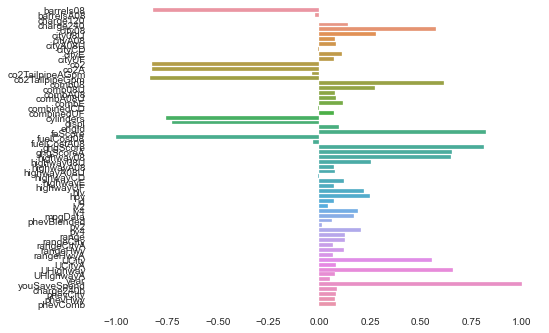

In [9]:
ax = sns.barplot(y=df.corr().youSaveSpend.index,x=df.corr().youSaveSpend.values)

In [10]:
df[~df['fuelType2'].isna()]['fuelType'].value_counts()
# the fueling arrangements for vehicles with a second 
# fuel type, an over-complication that caters to a small number of vehicles

Gasoline or E85                1339
Premium or E85                  127
Premium and Electricity          75
Regular Gas and Electricity      51
Premium Gas or Electricity       49
Gasoline or natural gas          20
Gasoline or propane               8
Regular Gas or Electricity        4
Name: fuelType, dtype: int64

### Cleaning

In [23]:
# some sort of wrangle function
def wrangle(df):
    # about 4% of vehicles use fuelType2, only going to focus on single fueltype
    idx = df[~df['fuelType2'].isna()].index
    df = df.drop(index=idx)
    
    # convert datetime    
    df['modifiedOn'] = pd.to_datetime(df['modifiedOn'])
    df['modifiedOn_year'] = df['modifiedOn'].dt.year
    df['modifiedOn_month'] = df['modifiedOn'].dt.month
    df['modifiedOn_day'] = df['modifiedOn'].dt.day    
    
    # guzzler: if G or T, then true
    df['guzzler'] = df['guzzler'].replace('T',True).replace('G',True)
    df['guzzler'].fillna(False,inplace=True)
    
    # sCharger, tCharger: if S or T, the vehicle is super-/turbocharged
    df['sCharger'] = df['sCharger'].replace('S',True)
    df['sCharger'].fillna(False,inplace=True)
    df['tCharger'] = df['tCharger'].replace('T',True)
    df['tCharger'].fillna(False,inplace=True)
    
    # zero in 'engId' should mean NaN, no it shouldn't because imputing will give it the average
    #df['engId'] = df['engId'].replace(0,np.nan)
    
    # GATHER DROP COLS
    #engine description might be worth the high cardinality if half of them weren't missing
    highcard_drops = ['eng_dscr','id']
    #these are direct copies of other cols, or are "unrounded" versions that are zero 75% of the time
    #UCity + UHighway are mpg's not temperature-adjusted
    redundant_drops = ['fuelType1','modifiedOn','createdOn','city08U','highway08U','comb08U','UCity','UHighway']
    # ID other cols with too many nulls/zeros
    null_drops = df.columns[df.isna().sum()/len(df) > 0.8].tolist() + ['co2']
    null_drops.remove('evMotor')
    null_drops.remove('atvType')
    zero_drops = df.columns[(df==0).sum()/len(df) > 0.8].tolist() + ['lv4','pv4']
    zero_drops.remove('sCharger')
    zero_drops.remove('tCharger')
    drops = highcard_drops + redundant_drops + null_drops + zero_drops 
    #feScore is leaky
    drops.append('feScore')
        
    print('Null Drops:\n',null_drops)
    print('Zero Drops:\n',zero_drops)
    
    # Engineer feature
    df['vehicle_age'] = df['modifiedOn_year'] - df['year']
    #something that conveys the emissions from electricity generation would be great
    
    return df.drop(columns=drops)
    
df_wrangled = wrangle(df)


C:\Users\Owner\anaconda3\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\Users\Owner\anaconda3\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


Null Drops:
 ['co2A', 'ghgScoreA', 'fuelType2', 'rangeA', 'c240Dscr', 'c240bDscr', 'co2']
Zero Drops:
 ['barrelsA08', 'charge120', 'charge240', 'cityA08', 'cityA08U', 'cityCD', 'cityE', 'cityUF', 'co2TailpipeAGpm', 'combA08', 'combA08U', 'combE', 'combinedCD', 'combinedUF', 'fuelCostA08', 'highwayA08', 'highwayA08U', 'highwayCD', 'highwayE', 'highwayUF', 'hlv', 'hpv', 'lv2', 'phevBlended', 'pv2', 'range', 'rangeCity', 'rangeCityA', 'rangeHwy', 'rangeHwyA', 'UCityA', 'UHighwayA', 'guzzler', 'charge240b', 'phevCity', 'phevHwy', 'phevComb', 'lv4', 'pv4']


In [12]:
df_wrangled.columns

Index(['barrels08', 'city08', 'co2TailpipeGpm', 'comb08', 'cylinders', 'displ',
       'drive', 'engId', 'fuelCost08', 'fuelType', 'highway08', 'make',
       'model', 'mpgData', 'trany', 'VClass', 'year', 'youSaveSpend',
       'trans_dscr', 'tCharger', 'sCharger', 'atvType', 'evMotor', 'mfrCode',
       'startStop', 'modifiedOn_year', 'modifiedOn_month', 'modifiedOn_day',
       'vehicle_age'],
      dtype='object')

In [40]:
df[(df['make']=='Chevrolet') & (df['model']=='Impala') & (df['year']==2015)]

barrels08  barrelsA08  charge120  charge240  city08  city08U  cityA08  \
27499  15.695714    0.000000        0.0        0.0      18  17.8248        0   
27500  14.982273    4.681875        0.0        0.0      19  18.7801       14   
27501  13.184400    0.000000        0.0        0.0      22  22.0000        0   

       cityA08U  cityCD  cityE  cityUF    co2   co2A  co2TailpipeAGpm  \
27499    0.0000     0.0    0.0     0.0  419.0    NaN              0.0   
27500   13.8463     0.0    0.0     0.0  401.0  387.0            387.0   
27501    0.0000     0.0    0.0     0.0  355.0    NaN              0.0   

       co2TailpipeGpm  ...  sCharger  atvType  fuelType2  rangeA  evMotor  \
27499           419.0  ...       NaN      NaN        NaN     NaN      NaN   
27500           401.0  ...       NaN      FFV        E85     298      NaN   
27501           355.0  ...       NaN      NaN        NaN     NaN      NaN   

       mfrCode  c240Dscr  charge240b  c240bDscr                     createdOn  \
27499      GMX       NaN         0.0        NaN  Fri Jun 06 00:00:00 EDT 2014   
27500      GMX       NaN         0.0        NaN  Fri Jun 06 00:00:00 EDT 2014   
27501      GMX       NaN         0.0        NaN  Fri Jun 06 00:00:00 EDT 2014   

                         modifiedOn startStop  phevCity  phevHwy  phevComb  
27499  Mon Sep 26 00:00:00 EDT 2016     False         0        0         0  
27500  Mon Sep 26 00:00:00 EDT 2016     False         0        0         0  
27501  Mon Sep 26 00:00:00 EDT 2016      True         0        0         0  

[3 rows x 83 columns]

In [62]:
flexfuels = df[df['atvType']=='FFV'].drop(columns=['charge120','charge240','city08U',
                                       'cityA08U','cityCD','cityE','cityUF',
                                       'phevCity','phevHwy','phevComb',
                                       'combA08U','comb08U','combE','combinedCD',
                                      'combinedUF','evMotor','mfrCode',
                                       'c240Dscr','charge240b','c240bDscr',
                                       'UHighway','UHighwayA','UCity',
                                       'UCityA','engId','phevBlended',
                                       'pv2','pv4','lv2','lv4','highway08U',
                                      'highwayA08U','id'])
flexfuels['barrel_diff'] = flexfuels['barrels08'] - flexfuels['barrelsA08']
flexfuels['co2_diff'] = flexfuels['co2TailpipeGpm'] - flexfuels['co2TailpipeAGpm']
flexfuels['comb_mpg_diff'] = flexfuels['comb08'] - flexfuels['combA08']

In [76]:
flexfuels[flexfuels['make']==('Chevrolet' or 'GMC' or 'Ford' or 'Dodge')].sort_values(by='co2TailpipeGpm')

barrels08  barrelsA08  city08  cityA08  co2  co2A  co2TailpipeAGpm  \
22522  12.677308    3.942632      22       16  NaN   NaN       331.157895   
20633  12.677308    3.942632      22       16  NaN   NaN       331.157895   
20515  12.677308    4.161667      22       15  NaN   NaN       349.555556   
17333  12.677308    3.942632      22       16  NaN   NaN       331.157895   
23583  12.677308    4.406471      22       15  NaN   NaN       370.117647   
...          ...         ...     ...      ...  ...   ...              ...   
24026  27.467500    8.323333      10        7  NaN   NaN       699.111111   
24025  27.467500    8.323333      10        8  NaN   NaN       699.111111   
24023  27.467500    8.323333      10        8  NaN   NaN       699.111111   
22497  27.467500    8.323333      11        8  NaN   NaN       699.111111   
22485  27.467500    8.323333      10        8  NaN   NaN       699.111111   

       co2TailpipeGpm  comb08  combA08  cylinders  displ              drive  \
22522      341.807692      26       19        4.0    2.2  Front-Wheel Drive   
20633      341.807692      26       19        4.0    2.2  Front-Wheel Drive   
20515      341.807692      26       18        4.0    2.4  Front-Wheel Drive   
17333      341.807692      26       19        4.0    2.2  Front-Wheel Drive   
23583      341.807692      26       17        4.0    2.4  Front-Wheel Drive   
...               ...     ...      ...        ...    ...                ...   
24026      740.583333      12        9        8.0    6.0   Rear-Wheel Drive   
24025      740.583333      12        9        8.0    6.0   Rear-Wheel Drive   
24023      740.583333      12        9        8.0    6.0   Rear-Wheel Drive   
22497      740.583333      12        9        8.0    6.0   Rear-Wheel Drive   
22485      740.583333      12        9        8.0    6.0   Rear-Wheel Drive   

        eng_dscr  feScore  fuelCost08  fuelCostA08         fuelType  \
22522        FFV      NaN        1050         1800  Gasoline or E85   
20633        FFV      NaN        1050         1800  Gasoline or E85   
20515        FFV      NaN        1050         1900  Gasoline or E85   
17333        NaN      NaN        1050         1800  Gasoline or E85   
23583  SIDI; FFV      NaN        1050         2000  Gasoline or E85   
...          ...      ...         ...          ...              ...   
24026        FFV      NaN        2250         3800  Gasoline or E85   
24025        FFV      NaN        2250         3800  Gasoline or E85   
24023        FFV      NaN        2250         3800  Gasoline or E85   
22497        FFV      NaN        2250         3800  Gasoline or E85   
22485        FFV      NaN        2250         3800  Gasoline or E85   

              fuelType1  ghgScore  ghgScoreA  highway08  highwayA08  \
22522  Regular Gasoline       NaN        NaN         31          22   
20633  Regular Gasoline       NaN        NaN         32          23   
20515  Regular Gasoline       NaN        NaN         33          23   
17333  Regular Gasoline       NaN        NaN         32          23   
23583  Regular Gasoline       NaN        NaN         31          21   
...                 ...       ...        ...        ...         ...   
24026  Regular Gasoline       NaN        NaN         14          11   
24025  Regular Gasoline       NaN        NaN         15          11   
24023  Regular Gasoline       NaN        NaN         15          11   
22497  Regular Gasoline       NaN        NaN         16          12   
22485  Regular Gasoline       NaN        NaN         16          12   

       highwayCD  highwayE  ...       make                              model  \
22522        0.0       0.0  ...  Chevrolet                      HHR Panel FWD   
20633        0.0       0.0  ...  Chevrolet                            HHR FWD   
20515        0.0       0.0  ...  Chevrolet                             Malibu   
17333        0.0       0.0  ...  Chevrolet                            HHR FWD   
23583        0.0      

In [64]:
flexfuels.sort_values('barrel_diff').head(10)

barrels08  barrelsA08  city08  cityA08    co2   co2A  co2TailpipeAGpm  \
24502  10.300313    3.405000      28       19    NaN    NaN            286.0   
25187  10.300313    3.405000      28       19  278.0  281.0            281.0   
26445  10.300313    3.405000      28       19  278.0  281.0            281.0   
24501  10.632581    3.405000      27       19    NaN    NaN            286.0   
25676  10.632581    3.405000      27       19    NaN    NaN            286.0   
28541  10.632581    3.256957      27       20  285.0  270.0            270.0   
31303  10.632581    3.256957      26       20  289.0  278.0            278.0   
29652  10.632581    3.256957      27       20  285.0  270.0            270.0   
26385  10.987000    3.405000      26       20  296.0  281.0            281.0   
26384  10.987000    3.405000      26       20  296.0  281.0            281.0   

       co2TailpipeGpm  comb08  combA08  cylinders  displ              drive  \
24502      277.718750      32       22        4.0    2.0  Front-Wheel Drive   
25187      278.000000      32       22        4.0    2.0  Front-Wheel Drive   
26445      278.000000      32       22        4.0    2.0  Front-Wheel Drive   
24501      286.677419      31       22        4.0    2.0  Front-Wheel Drive   
25676      286.677419      31       22        4.0    2.0  Front-Wheel Drive   
28541      285.000000      31       23        4.0    2.0  Front-Wheel Drive   
31303      289.000000      31       23        4.0    2.0  Front-Wheel Drive   
29652      285.000000      31       23        4.0    2.0  Front-Wheel Drive   
26385      296.000000      30       22        4.0    2.0  Front-Wheel Drive   
26384      296.000000      30       22        4.0    2.0  Front-Wheel Drive   

        eng_dscr  feScore  fuelCost08  fuelCostA08         fuelType  \
24502  SIDI; FFV      NaN         850         1550  Gasoline or E85   
25187  SIDI; FFV      8.0         850         1550  Gasoline or E85   
26445  SIDI; FFV      8.0         850         1550  Gasoline or E85   
24501  SIDI; FFV      NaN         900         1550  Gasoline or E85   
25676  SIDI; FFV      NaN         900         1550  Gasoline or E85   
28541  SIDI; FFV      8.0         900         1500  Gasoline or E85   
31303  SIDI; FFV      7.0         900         1500  Gasoline or E85   
29652  SIDI; FFV      7.0         900         1500  Gasoline or E85   
26385  SIDI; FFV      8.0         900         1550  Gasoline or E85   
26384  SIDI; FFV      8.0         900         1550  Gasoline or E85   

              fuelType1  ghgScore  ghgScoreA  highway08  highwayA08  \
24502  Regular Gasoline       NaN        NaN         39          27   
25187  Regular Gasoline       8.0        8.0         39          27   
26445  Regular Gasoline       8.0        8.0         39          27   
24501  Regular Gasoline       NaN        NaN         37          27   
25676  Regular Gasoline       NaN        NaN         36          27   
28541  Regular Gasoline       8.0        8.0         39          28   
31303  Regular Gasoline       7.0        7.0         38          28   
29652  Regular Gasoline       7.0        8.0         39          28   
26385  Regular Gasoline       8.0        8.0         36          27   
26384  Regular Gasoline       8.0        8.0         36          27   

       highwayCD  highwayE  ...  make              model  mpgData range  \
24502        0.0       0.0  ...  Ford  Focus SFE FWD FFV     True     0   
25187        0.0       0.0  ...  Ford  Focus SFE FWD FFV     True     0   
26445        0.0       0.0  ...  Ford  Focus SFE FWD FFV     True     0   
24501        0.0       0.0  ...  Ford      Focus FWD FFV     True     0   
25676        0.0       0.0  ...  Ford      Focus FWD FFV     True     0   
28541        0.0       0.0  ...  Ford      Focus FWD FFV    False     0   
31303        0.0       0.0  ...  Ford      Focus FWD FFV    False     0   
29652        0.0       0.0  ...  Ford      Focus FWD FFV    False     0   
26385        0.0 

In [65]:
flexfuels.sort_values('barrel_diff').tail(10)

barrels08  barrelsA08  city08  cityA08    co2   co2A  co2TailpipeAGpm  \
22500    27.4675    8.323333      11        8    NaN    NaN       699.111111   
22497    27.4675    8.323333      11        8    NaN    NaN       699.111111   
22489    27.4675    8.323333      10        8    NaN    NaN       699.111111   
22488    27.4675    8.323333      10        8    NaN    NaN       699.111111   
22486    27.4675    8.323333      10        8    NaN    NaN       699.111111   
22485    27.4675    8.323333      10        8    NaN    NaN       699.111111   
24721    27.4675    8.323333      10        8  740.0  713.0       713.000000   
24025    27.4675    8.323333      10        8    NaN    NaN       699.111111   
14042    27.4675    8.323333      11        8    NaN    NaN       699.111111   
24023    27.4675    8.323333      10        8    NaN    NaN       699.111111   

       co2TailpipeGpm  comb08  combA08  cylinders  displ  \
22500      740.583333      12        9        8.0    6.0   
22497      740.583333      12        9        8.0    6.0   
22489      740.583333      12        9        8.0    6.0   
22488      740.583333      12        9        8.0    6.0   
22486      740.583333      12        9        8.0    6.0   
22485      740.583333      12        9        8.0    6.0   
24721      740.000000      12        9        8.0    6.0   
24025      740.583333      12        9        8.0    6.0   
14042      740.583333      12        9        8.0    4.7   
24023      740.583333      12        9        8.0    6.0   

                            drive   eng_dscr  feScore  fuelCost08  \
22500            Rear-Wheel Drive        FFV      NaN        2250   
22497            Rear-Wheel Drive        FFV      NaN        2250   
22489            Rear-Wheel Drive        FFV      NaN        2250   
22488            Rear-Wheel Drive        FFV      NaN        2250   
22486            Rear-Wheel Drive        FFV      NaN        2250   
22485            Rear-Wheel Drive        FFV      NaN        2250   
24721            Rear-Wheel Drive        FFV      1.0        2250   
24025            Rear-Wheel Drive        FFV      NaN        2250   
14042  4-Wheel or All-Wheel Drive  FLEX-FUEL      NaN        2250   
24023            Rear-Wheel Drive        FFV      NaN        2250   

       fuelCostA08         fuelType         fuelType1  ghgScore  ghgScoreA  \
22500         3800  Gasoline or E85  Regular Gasoline       NaN        NaN   
22497         3800  Gasoline or E85  Regular Gasoline       NaN        NaN   
22489         3800  Gasoline or E85  Regular Gasoline       NaN        NaN   
22488         3800  Gasoline or E85  Regular Gasoline       NaN        NaN   
22486         3800  Gasoline or E85  Regular Gasoline       NaN        NaN   
22485         3800  Gasoline or E85  Regular Gasoline       NaN        NaN   
24721         3800  Gasoline or E85  Regular Gasoline       1.0        1.0   
24025         3800  Gasoline or E85  Regular Gasoline       NaN        NaN   
14042         3800  Gasoline or E85  Regular Gasoline       NaN        NaN   
24023         3800  Gasoline or E85  Regular Gasoline       NaN        NaN   

       highway08  highwayA08  highwayCD  highwayE  ...       make  \
22500         16          12        0.0       0.0  ...        GMC   
22497         16          12        0.0       0.0  ...  Chevrolet   
22489         16          12        0.0       0.0  ...        GMC   
22488         16          12        0.0       0.0  ...        GMC   
22486         16          12        0.0       0.0  ...        GMC   
22485         16          12        0.0       0.0  ...  Chevrolet   
24721         15          11        0.0       0.0  ...  Chevrolet   
24025         15          11        0.0       0.0  ...  Chevrolet   
14042         14          11        0.0       0.0  ...      Dodge   
24023         15          11        0.0       0.0  ...  Chevrolet   

                                    model  mpgData range rangeCity  \
22500         Sa

In [31]:
#Toyota vehicles
toyota = df_wrangled[df_wrangled['make'] =='Toyota']

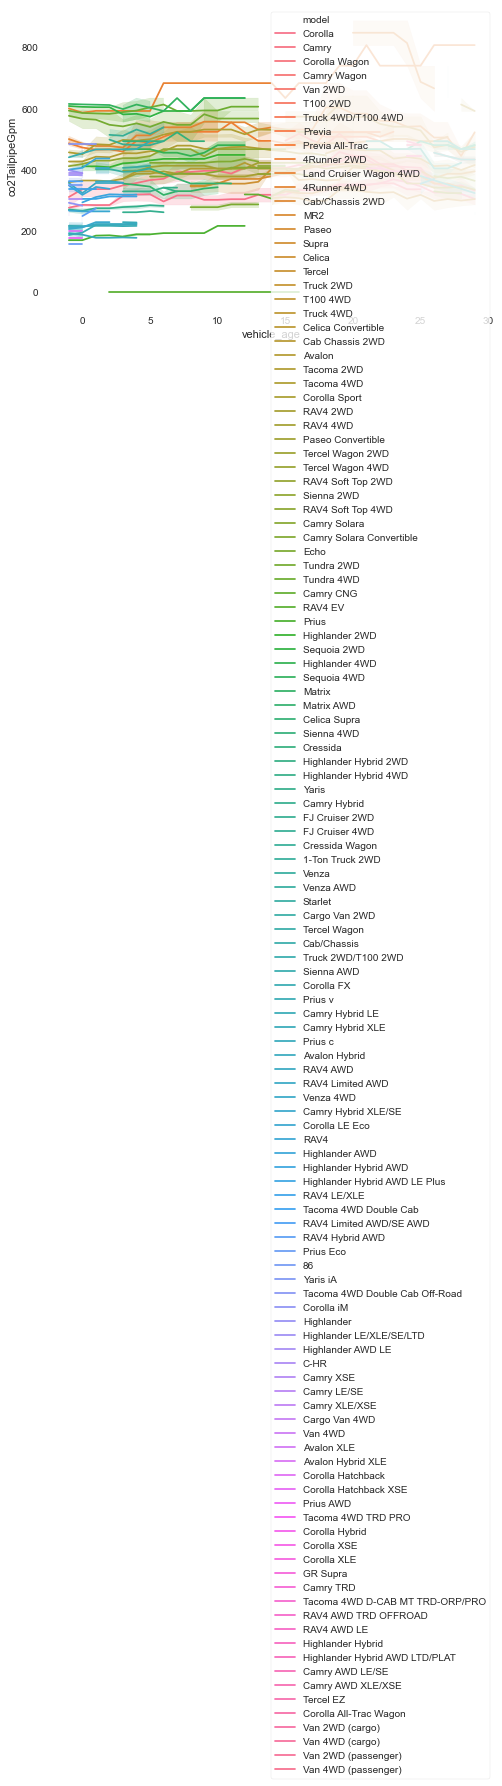

In [32]:
sns.lineplot(data=toyota,x='vehicle_age',y='co2TailpipeGpm',hue='model')

In [13]:
df_wrangled.profile_report()

In [14]:
df_wrangled['atvType'].value_counts()
#might focus the model on just petroleum cars if these throw off the model too much

Diesel    1130
Hybrid     672
EV         237
CNG         50
Name: atvType, dtype: int64

### Examine cleaned data

In [15]:
df_wrangled[df_wrangled['fuelType']=='Electricity']
#Electric cars have weird entries, but no numeric columns have NaN's 
# that would be a severe misrepresentation if imputed with medians

barrels08  city08  co2TailpipeGpm  comb08  cylinders  displ  \
7138       0.240      81             0.0      85        NaN    NaN   
7139       0.282      81             0.0      72        NaN    NaN   
8143       0.282      81             0.0      72        NaN    NaN   
8144       0.312      74             0.0      65        NaN    NaN   
8146       0.522      45             0.0      39        NaN    NaN   
...          ...     ...             ...     ...        ...    ...   
35769      0.180     123             0.0     112        NaN    NaN   
35821      0.180     123             0.0     111        NaN    NaN   
35822      0.186     118             0.0     108        NaN    NaN   
35823      0.192     114             0.0     104        NaN    NaN   
35853      0.294      68             0.0      69        NaN    NaN   

                   drive  engId  fuelCost08     fuelType  highway08     make  \
7138                 NaN      0         800  Electricity         91   Nissan   
7139       2-Wheel Drive      0         900  Electricity         64   Toyota   
8143       2-Wheel Drive      0         900  Electricity         64   Toyota   
8144                 NaN      0        1000  Electricity         58     Ford   
8146       2-Wheel Drive      0        1700  Electricity         33     Ford   
...                  ...    ...         ...          ...        ...      ...   
35769  Front-Wheel Drive     39         600  Electricity        102      Kia   
35821  Front-Wheel Drive    902         600  Electricity         99   Nissan   
35822  Front-Wheel Drive    903         600  Electricity         97   Nissan   
35823  Front-Wheel Drive    904         650  Electricity         94   Nissan   
35853    All-Wheel Drive    712         950  Electricity         71  Porsche   

                                    model  mpgData           trany  \
7138                             Altra EV    False             NaN   
7139                              RAV4 EV    False             NaN   
8143                              RAV4 EV    False             NaN   
8144                                Th!nk    False             NaN   
8146               Explorer USPS Electric    False             NaN   
...                                   ...      ...             ...   
35769                       Niro Electric    False  Automatic (A1)   
35821        Leaf (40 kW-hr battery pack)    False  Automatic (A1)   
35822        Leaf (62 kW-hr battery pack)    False  Automatic (A1)   
35823  Leaf SV/SL (62 kW-hr battery pack)    False  Automatic (A1)   
35853         Taycan 4S Perf Battery Plus    False  Automatic (A2)   

                            VClass  year  youSaveSpend trans_dscr  tCharger  \
7138        Midsize Station Wagons  2000          1000        NaN     False   
7139   Sport Utility Vehicle - 2WD  2000           500        NaN     False   
8143   Sport Utility Vehicle - 2WD  2001           500        NaN     False   
8144                   Two Seaters  2001             0        NaN     False   
8146   Sport Utility Vehicle - 2WD  2001         -3500        NaN     False   
...                            ...   ...           ...        ...       ...   
35769         Small Station Wagons  2020          2000        NaN     False   
35821                 Midsize Cars  2020          2000        NaN     False   
35822                 Midsize Cars  2020          2000        NaN     False   
35823                 Midsize Cars  2020          1750        NaN     False   
35853                   Large Cars  2020           250        NaN     False   

       sCharger atvType             evMotor mfrCode startStop  \
7138      False      EV  62 KW AC Induction     NaN     False   
7139      False      EV            50 KW DC     NaN     False   
8143      False      EV            50 KW DC     NaN     False   
8144      False      EV  27 KW AC Induction     NaN     False   
8146      False      EV  67 KW AC Induction     NaN     False   
...         ...     ...  

### Target selection

In [16]:
from sklearn.model_selection import train_test_split

In [24]:
# Train/test/val split
train, test = train_test_split(df_wrangled,random_state=42,test_size=0.15)
train.shape, test.shape

((34473, 30), (6084, 30))

In [25]:
train, val = train_test_split(train,random_state=42,test_size=6084)
# Feature/target definition
target = 'ghgScore'
features = train.columns.drop(target)

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]
features

Index(['barrels08', 'city08', 'co2TailpipeGpm', 'comb08', 'cylinders', 'displ',
       'drive', 'engId', 'fuelCost08', 'fuelType', 'highway08', 'make',
       'model', 'mpgData', 'trany', 'VClass', 'year', 'youSaveSpend',
       'trans_dscr', 'tCharger', 'sCharger', 'atvType', 'evMotor', 'mfrCode',
       'startStop', 'modifiedOn_year', 'modifiedOn_month', 'modifiedOn_day',
       'vehicle_age'],
      dtype='object')

## Model and pipeline creation

In [26]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

In [27]:
pipeline = make_pipeline(ce.OrdinalEncoder(),
                         SimpleImputer(strategy='mean'),
                         RandomForestRegressor(n_estimators=50,min_samples_leaf=5,random_state=42,n_jobs=-1))

In [28]:
pipeline.fit(X_train,y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [29]:
pipeline.score(X_val,y_val)

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.